In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib

# ---------------- Step 1: Load & Preprocess January Data ----------------
df_jan = pd.read_csv("train.csv", parse_dates=['timestamp'])
df_jan = df_jan.sort_values("timestamp")

# Use only temperature values
temps = df_jan['body_temperature'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(temps)

# Create sequences
sequence_length = 4
X, y = [], []
for i in range(len(temps_scaled) - sequence_length):
    X.append(temps_scaled[i:i+sequence_length])
    y.append(temps_scaled[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Train/Test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# ---------------- Step 2: Build and Train LSTM ----------------
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=1)

# Evaluate
loss = model.evaluate(X_test, y_test)
print("RMSE:", np.sqrt(loss))

# Save model and scaler
model.save("lstm_body_temp_model.h5")
joblib.dump(scaler, "lstm_scaler.save")

# ---------------- Step 3: Load February Data and Predict ----------------
df_feb = pd.read_csv("test.csv", parse_dates=['timestamp'])
df_feb = df_feb.sort_values("timestamp")

# Normalize February values
temps_feb = df_feb['body_temperature'].values.reshape(-1, 1)
temps_feb_scaled = scaler.transform(temps_feb)

# Create sequences for February
X_feb = []
for i in range(len(temps_feb_scaled) - sequence_length):
    X_feb.append(temps_feb_scaled[i:i+sequence_length])
X_feb = np.array(X_feb)

# Predict
pred_scaled = model.predict(X_feb)
pred = scaler.inverse_transform(pred_scaled)

# Append predictions to February data
df_feb = df_feb.iloc[sequence_length:].copy()
df_feb['predicted_temperature'] = pred

# Save results
df_feb.to_csv("february_2025_lstm_predictions.csv", index=False)
print("Predictions saved to 'february_2025_lstm_predictions.csv'")





Epoch 1/50

3/3 [==============================] - 1s 5ms/step - loss: 0.3050
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2822
Epoch 3/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2597
Epoch 4/50
3/3 [==============================] - 0s 5ms/step - loss: 0.2391
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2195
Epoch 6/50
3/3 [==============================] - 0s 5ms/step - loss: 0.2004
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1811
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1637
Epoch 9/50
3/3 [==============================] - 0s 4ms/step - loss: 0.1455
Epoch 10/50
3/3 [==============================] - 0s 5ms/step - loss: 0.1275
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1100
Epoch 12/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0940
Epoch 13/50
3/3 [==============================] - 0s 4ms/step - loss

C:\Users\jayan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 2ms/step
Predictions saved to 'february_2025_lstm_predictions.csv'


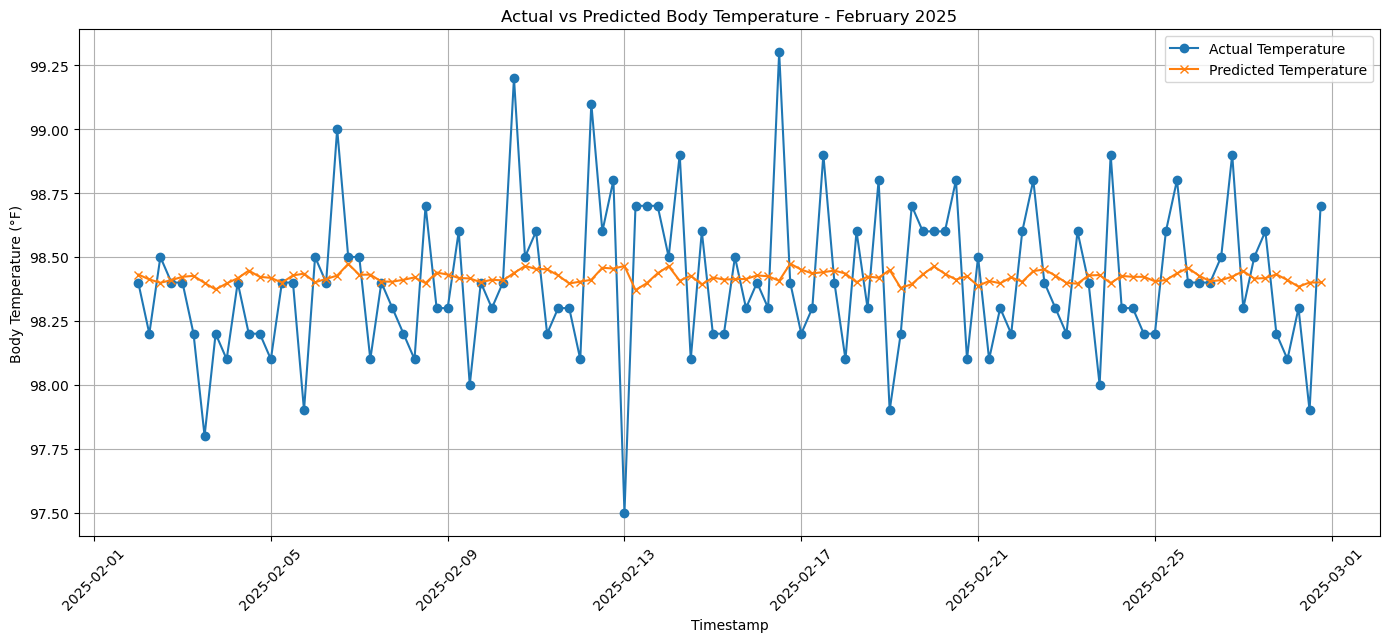

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data with predictions
df_feb = pd.read_csv("february_2025_lstm_predictions.csv", parse_dates=['timestamp'])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_feb['timestamp'], df_feb['body_temperature'], label='Actual Temperature', marker='o')
plt.plot(df_feb['timestamp'], df_feb['predicted_temperature'], label='Predicted Temperature', marker='x')

plt.title("Actual vs Predicted Body Temperature - February 2025")
plt.xlabel("Timestamp")
plt.ylabel("Body Temperature (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
